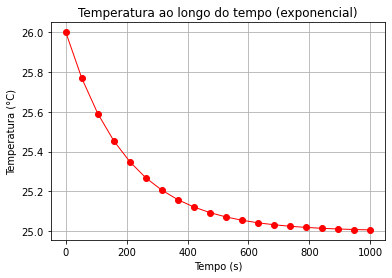

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Atividade 4.1

#Resolução da EDO analítica 

# Parâmetros fornecidos
T_prime = 25       # temperatura inicial em ºC
r = 0.005          # taxa exponencial em 1/s

# Lista de tempos de 0 a 1000 s com 201 pontos
t = np.linspace(0, 1000, 20)

# Cálculo da temperatura com decaimento exponencial
T = T_prime + np.exp(-r * t)

# Plotar o gráfico com linha mais fina
plt.plot(t, T, marker='o', linestyle='-', color='red', linewidth=1)
plt.title("Temperatura ao longo do tempo (exponencial)")
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()


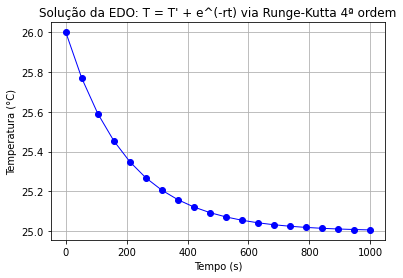

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Atividade 4.2

#Resolução da EDO por RK4

# Parâmetros do problema
T_prime = 25
r = 0.005
t0 = 0
tf = 1000
n = 20  # número de pontos
h = (tf - t0) / (n - 1)

# Função derivada dT/dt
def f(t, T):
    return -r * np.exp(-r * t)

# Condição inicial
t_vals = [t0]
T_vals = [T_prime + np.exp(-r * t0)]  # T(0) = 25 + e^0 = 26

# Método de Runge-Kutta de 4ª ordem
for i in range(1, n):
    t_n = t_vals[-1]
    T_n = T_vals[-1]

    k1 = h * f(t_n, T_n)
    k2 = h * f(t_n + h/2, T_n + k1/2)
    k3 = h * f(t_n + h/2, T_n + k2/2)
    k4 = h * f(t_n + h, T_n + k3)

    T_next = T_n + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
    t_next = t_n + h

    t_vals.append(t_next)
    T_vals.append(T_next)

# Plotar
plt.plot(t_vals, T_vals, marker='o', linestyle='-', color='blue', linewidth=1)
plt.title("Solução da EDO: T = T' + e^(-rt) via Runge-Kutta 4ª ordem")
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.show()


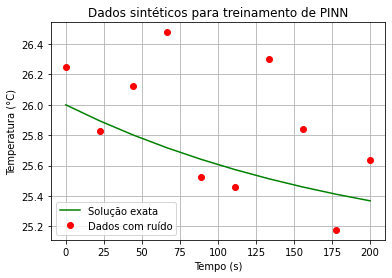

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Atividade 4.3.1

# Parâmetros
T_env = 25         # Temperatura ambiente
r = 0.005          # Constante de resfriamento
n_points = 10      # Número de dados sintéticos
t_data = np.linspace(0, 200, n_points)  # Intervalo [0, 200] s

# Solução exata (como no modelo RK4 anterior)
T_true = T_env + np.exp(-r * t_data)

# Adiciona ruído gaussiano
np.random.seed(42)  # Reprodutibilidade
noise = np.random.normal(loc=0.0, scale=0.5, size=t_data.shape)
T_noisy = T_true + noise

# Conversão para tensores do PyTorch
t_train = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
T_train = torch.tensor(T_noisy, dtype=torch.float32).view(-1, 1)

def data_loss(model, t_train, T_train):
    pred = model(t_train)
    return torch.mean((pred - T_train) ** 2)

# Visualização
plt.plot(t_data, T_true, 'g-', label='Solução exata')
plt.plot(t_data, T_noisy, 'ro', label='Dados com ruído')
plt.title("Dados sintéticos para treinamento de PINN")
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.legend()
plt.show()


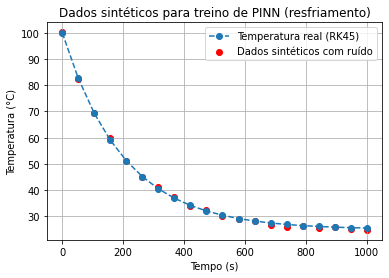

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#Atividade 4.3.2 - Versão Alternativa

#Utilizando a PINN

# Parâmetros do problema
T_amb = 25        # Temperatura ambiente (°C)
T0 = 100          # Temperatura inicial do café (°C)
r = 0.005         # Constante de resfriamento (1/s)
t_final = 1000    # Tempo final para geração de dados
n_points = 20     # Quantidade de pontos desejados

# Definição da EDO: dT/dt = -r * (T - T_amb)
def cooling_law(t, T):
    return -r * (T - T_amb)

# Intervalo de tempo
t_span = (0, t_final)
y0 = [T0]

# Pontos onde queremos a solução (exatamente n_points)
t_eval = np.linspace(t_span[0], t_span[1], n_points)

# Resolver a EDO com RK45
sol = solve_ivp(cooling_law, t_span, y0, t_eval=t_eval, method='RK45')

# Extrair solução numérica
t_data = sol.t
T_data = sol.y[0]

# Adicionar ruído gaussiano (média 0, desvio padrão 0.5)
np.random.seed(42)
noise = np.random.normal(0, 0.5, size=T_data.shape)
T_noisy = T_data + noise


# Plotar dados limpos e com ruído
plt.plot(t_data, T_data, label='Temperatura real (RK45)', linestyle='--', marker='o')
plt.scatter(t_data, T_noisy, label='Dados sintéticos com ruído', color='red')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Dados sintéticos para treino de PINN (resfriamento)')
plt.legend()
plt.grid(True)
plt.show()


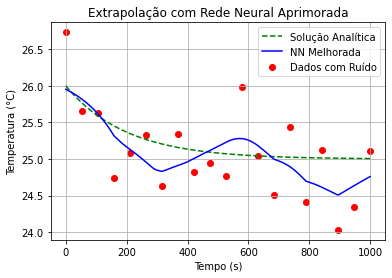

In [35]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Atividade 4.4

# ===== Dados sintéticos com ruído =====
T_prime = 25
r = 0.005
t_train = np.linspace(0, 1000, 20)
T_clean = T_prime + np.exp(-r * t_train)
T_noisy = T_clean + np.random.normal(0, 0.5, size=T_clean.shape)

# Normalização do tempo (entrada)
t_mean = np.mean(t_train)
t_std = np.std(t_train)
t_train_norm = (t_train - t_mean) / t_std
x_train = torch.tensor(t_train_norm, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(T_noisy, dtype=torch.float32).unsqueeze(1)

# ===== Rede neural com maior capacidade =====
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1)
)

# ===== Treinamento =====
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(5000):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# ===== Previsão =====
t_test = np.linspace(0, 1000, 300)
t_test_norm = (t_test - t_mean) / t_std
x_test = torch.tensor(t_test_norm, dtype=torch.float32).unsqueeze(1)
with torch.no_grad():
    y_test_pred = model(x_test).squeeze().numpy()

# ===== Solução analítica =====
T_true = T_prime + np.exp(-r * t_test)

# ===== Gráfico =====
plt.plot(t_test, T_true, 'g--', label='Solução Analítica')
plt.plot(t_test, y_test_pred, 'b-', label='NN Melhorada')
plt.scatter(t_train, T_noisy, color='red', label='Dados com Ruído')
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.title('Extrapolação com Rede Neural Aprimorada')
plt.legend()
plt.grid(True)
plt.show()


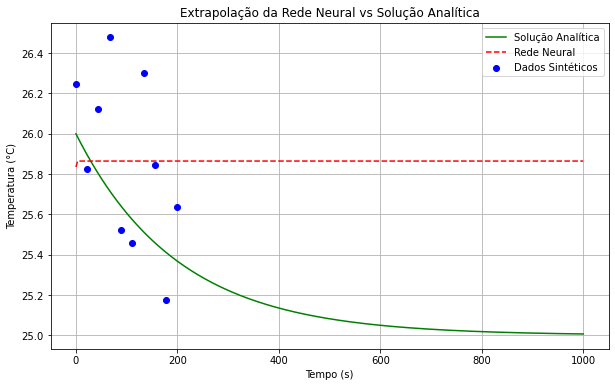

In [36]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Atividade 4.5

# Parâmetros físicos
T_env = 25
r = 0.005
n_points = 10

# Gerar pontos de tempo no intervalo de 0 a 200 s
t_data = np.linspace(0, 200, n_points)
T_exact = T_env + np.exp(-r * t_data)

# Adicionar ruído gaussiano
np.random.seed(42)
noise = np.random.normal(0, 0.5, size=t_data.shape)
T_noisy = T_exact + noise

# Converter para tensores PyTorch
t_train = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
T_train = torch.tensor(T_noisy, dtype=torch.float32).view(-1, 1)


# DEFINIR A REDE NEURAL SIMPLES

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = SimpleNN()

# TREINAR A REDE

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    pred = model(t_train)
    loss = loss_fn(pred, T_train)
    loss.backward()
    optimizer.step()

# EXTRAPOLAÇÃO E COMPARAÇÃO

# Criar pontos de avaliação de 0 até 1000 s
t_eval = np.linspace(0, 1000, 300)
t_eval_tensor = torch.tensor(t_eval, dtype=torch.float32).view(-1, 1)

# Predição da rede
model.eval()
with torch.no_grad():
    T_pred_nn = model(t_eval_tensor).numpy()

# Solução analítica exata
T_eval_exact = T_env + np.exp(-r * t_eval)

plt.figure(figsize=(10, 6))
plt.plot(t_eval, T_eval_exact, 'g-', label='Solução Analítica')
plt.plot(t_eval, T_pred_nn, 'r--', label='Rede Neural')
plt.scatter(t_data, T_noisy, color='blue', label='Dados Sintéticos', zorder=5)
plt.title("Extrapolação da Rede Neural vs Solução Analítica")
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.show()


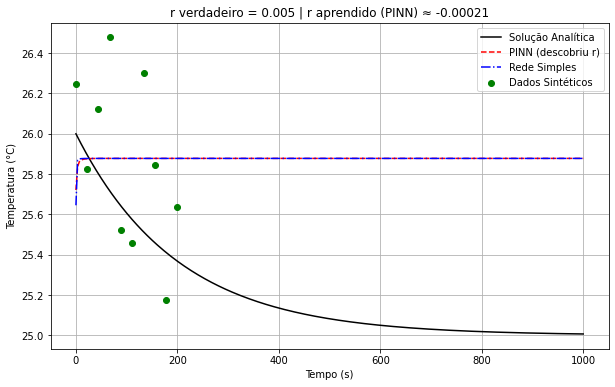

In [37]:
import torch
import torch.nn as nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt

# Atividade 4.6

# ----- CONFIGURAÇÕES -----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Tenv = 25.0  # Temperatura ambiente
r_true = 0.005  # valor verdadeiro usado só para gerar dados
np.random.seed(42)

# ----- GERAR DADOS SINTÉTICOS -----
t_data_np = np.linspace(0, 200, 10)
T_exact = Tenv + np.exp(-r_true * t_data_np)
T_noisy = T_exact + np.random.normal(0, 0.5, size=t_data_np.shape)

t_data = torch.tensor(t_data_np, dtype=torch.float32).view(-1, 1).to(DEVICE)
T_data = torch.tensor(T_noisy, dtype=torch.float32).view(-1, 1).to(DEVICE)

# ----- DEFINIR PINN -----
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        # Parâmetro treinável r
        self.r = nn.Parameter(data=torch.tensor([0.0], dtype=torch.float32))

    def forward(self, t):
        return self.net(t)

# ----- LOSS DE DADOS -----
def data_loss(model, t_data, T_data):
    T_pred = model(t_data)
    return torch.mean((T_pred - T_data) ** 2)

# ----- LOSS FÍSICA (DISCOVERY DE r) -----
def physics_loss_discovery(model):
    ts = torch.linspace(0, 1000, steps=1000).view(-1, 1).to(DEVICE).requires_grad_(True)
    temps = model(ts)
    dTdt = grad(temps, ts, torch.ones_like(temps), create_graph=True)[0]
    pde = model.r * (Tenv - temps) - dTdt
    return torch.mean(pde ** 2)

# ----- TREINAMENTO DA PINN -----
model_pinn = Net().to(DEVICE)
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=1e-3)

for epoch in range(3000):
    optimizer.zero_grad()
    loss_d = data_loss(model_pinn, t_data, T_data)
    loss_p = physics_loss_discovery(model_pinn)
    loss = loss_d + loss_p
    loss.backward()
    optimizer.step()

# ----- REDE DE REGRESSÃO SIMPLES -----
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model_simple = SimpleNN().to(DEVICE)
optimizer_simple = torch.optim.Adam(model_simple.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(2000):
    optimizer_simple.zero_grad()
    pred = model_simple(t_data)
    loss = loss_fn(pred, T_data)
    loss.backward()
    optimizer_simple.step()

# ----- COMPARAÇÃO -----
t_test_np = np.linspace(0, 1000, 300)
t_test = torch.tensor(t_test_np, dtype=torch.float32).view(-1, 1).to(DEVICE)

with torch.no_grad():
    T_analytical = Tenv + np.exp(-r_true * t_test_np)
    T_pinn = model_pinn(t_test).cpu().numpy()
    T_simple = model_simple(t_test).cpu().numpy()

# ----- VISUALIZAÇÃO -----
plt.figure(figsize=(10, 6))
plt.plot(t_test_np, T_analytical, 'k-', label='Solução Analítica')
plt.plot(t_test_np, T_pinn, 'r--', label='PINN (descobriu r)')
plt.plot(t_test_np, T_simple, 'b-.', label='Rede Simples')
plt.scatter(t_data_np, T_noisy, color='green', label='Dados Sintéticos', zorder=5)
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title(f"r verdadeiro = {r_true} | r aprendido (PINN) ≈ {model_pinn.r.item():.5f}")
plt.legend()
plt.grid(True)
plt.show()
